# Objectives

1. Plot Locus Coverage of Whole Genome.
1. Add Locus Coverage to Dataframe.
1. Plot Locus Coverage: Distribution.
1. Plot Locus Coverage: Phlyo.
1. Identify Interesting Samples.

---
# Setup

## Imports

In [1]:
import os
import subprocess
from Bio import Phylo
import copy
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import lines, patches, colors, gridspec, ticker
import seaborn as sns
import scipy.stats
from functions import *

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import numpy as np


## Variables

In [2]:
WILDCARDS = ["all", "chromosome", "full", "30"]
project_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/denmark/"
results_dir = project_dir

READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

NO_DATA_CHAR = "NA"

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)

plt.rcParams['lines.linewidth'] = 0.5

flierprops = dict(marker='o', markerfacecolor='black', markersize=1,
                   markeredgecolor='none')

D3_COL_PAL = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

## Paths

In [3]:
colors_path = os.path.join(
    results_dir,
    "augur/{}/{}/{}/filter{}/beast/colors.tsv"
    .format(READS_ORIGIN, LOCUS_NAME, PRUNE, MISSING_DATA)
)

tree_path = os.path.join(
    results_dir, 
    "augur/{}/{}/{}/filter{}/beast/all.timetree.nwk"
    .format(READS_ORIGIN, LOCUS_NAME, PRUNE, MISSING_DATA)
)
metadata_path = os.path.join(
    results_dir, 
    "augur/{}/{}/{}/filter{}/beast/metadata.tsv"
    .format(READS_ORIGIN, LOCUS_NAME, PRUNE, MISSING_DATA)
) 

cov_df_path = os.path.join(
    results_dir, 
    "locus_coverage_collect/{}/locus_coverage.txt"
    .format(READS_ORIGIN)
)

dep_df_path = os.path.join(
    results_dir, 
    "locus_coverage_collect/{}/locus_depth.txt"
    .format(READS_ORIGIN)
)
ref_gff_path = os.path.join(
    results_dir,
    "data/reference/GCA_000009065.1_ASM906v1_genomic/GCA_000009065.1_ASM906v1_genomic.gff"
)

# ------------------------------------------
# Output
out_dir = os.path.join(results_dir, "locus_coverage_collect/{}/".format(READS_ORIGIN))


## Import Tree

In [4]:
tree = Phylo.read(tree_path, format="newick")
tree.ladderize(reverse=True)

metadata_df = pd.read_csv(metadata_path, sep='\t')
metadata_df.set_index(metadata_df.columns[0], inplace=True)
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

#display(metadata_df)

## Import Locus Dataframes

In [5]:
cov_df = pd.read_csv(cov_df_path, sep='\t')
cov_df.set_index("Sample", inplace=True)

#display(cov_df)  

dep_df = pd.read_csv(dep_df_path, sep='\t')
dep_df.set_index("Sample", inplace=True)
               
#display(dep_df)

In [6]:
# Remove samples not in tree dataframe (ex. outgroup)
for sample in cov_df.index:
    if sample not in metadata_df.index:
        print("Dropping:",sample)
        cov_df.drop(sample, inplace=True)
        dep_df.drop(sample, inplace=True)

Dropping: GCA_000734805.1_ASM73480v1_genomic
Dropping: GCA_002412225.1_Y.pestis_A-1486_genomic
Dropping: GCA_001188675.1_ASM118867v1_genomic
Dropping: GCA_000324165.1_ASM32416v1_genomic
Dropping: GCA_000324065.1_ASM32406v1_genomic
Dropping: GCA_000323705.1_ASM32370v1_genomic
Dropping: GCA_000323405.1_ASM32340v1_genomic
Dropping: GCA_000323385.1_ASM32338v1_genomic


## Import Reference GFF

In [7]:
ref_gff_columns = [
        "seqname",
        "source",
        "feature",
        "start", #sequence numbering starting at 1.
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
        "id",
]

ref_gff_tsv = ref_gff_path + ".tsv"
subprocess.run(["rm", "-f", ref_gff_tsv]) 

with open(ref_gff_path) as infile:
    with open(ref_gff_tsv, "a") as outfile:
        ref_gff_read = infile.read().split("\n")
        for line in ref_gff_read:
            if not line.startswith("#"):
                split_line = line.strip().split("\t")
                attr = split_line[-1].split(";")
                attr_id = attr[0].split("=")
                if len(attr_id) < 2:
                    continue
                attr_id = attr_id[1]
                line += "\t{}".format(attr_id)
                outfile.write(line + "\n")
                
ref_df = pd.read_csv(ref_gff_tsv, sep='\t', header=None)
ref_df.columns = ref_gff_columns
ref_df.set_index("id", inplace=True)
#display(ref_df)

## Create Dataframes for replicons and genes

In [8]:
ref_rep_df = ref_df[ref_df["feature"] == "region"]
#display(ref_rep_df)

ref_gene_df = ref_df[ref_df["feature"] == "gene"]
#display(ref_gene_df)

## Separate Dataframe by Type

In [9]:
cov_rep_df = copy.deepcopy(cov_df)
cov_gene_df = copy.deepcopy(cov_df)
dep_rep_df = copy.deepcopy(dep_df)
dep_gene_df = copy.deepcopy(dep_df)
non_replicon_loci = []
non_gene_loci = []

for col in cov_df.columns:
    if col not in ref_rep_df.index:
        non_replicon_loci.append(col)
    if col not in ref_gene_df.index:
        non_gene_loci.append(col)
        
cov_rep_df.drop(columns=non_replicon_loci, inplace=True)
display(cov_rep_df)

dep_rep_df.drop(columns=non_replicon_loci, inplace=True)
#display(dep_rep_df)
       
cov_gene_df.drop(columns=non_gene_loci, inplace=True)
#display(cov_gene_df)

dep_gene_df.drop(columns=non_gene_loci, inplace=True)
#display(dep_gene_df)

,AL590842.1:1..4653728,AL117189.1:1..70305,AL117211.1:1..96210,AL109969.1:1..9612
Sample,,,,
SAMEA5818830,0.934851,0.918498,0.938333,0.793383
SAMEA5818829,0.937922,0.926719,0.939518,0.799209
SAMEA5818828,0.931307,0.917260,0.936576,0.803059
SAMEA5818826,0.944735,0.930304,0.940526,0.803163
SAMEA5818825,0.913759,0.909693,0.931681,0.778610
SAMEA5818822,0.913039,0.904160,0.928937,0.769247
SAMEA5818821,0.930688,0.914615,0.937325,0.794528
SAMEA5818818,0.928584,0.912737,0.937273,0.796817
SAMEA5818817,0.938245,0.930901,0.938780,0.802226


---
# pPCP1 Analysis

In [10]:
target_seqname = "AL109969"
target_locus = "AL109969.1:1..9612" # pPCP1
target_gene = "gene-YPPCP1.07" # pla
# Exclude IS100 and the IS100 transposase
exclude_samples = ["P187","P212","P387",]
exclude_genes = ["gene-YPPCP1.01", "gene-YPPCP1.02" ]
gene_labels = {
    "gene-YPPCP1.01": 
        {
            "label": "IS100",
            "coord": [87, 1109],
            "color" : "#c4c4c4",
        },
    "gene-YPPCP1.02": 
        {
            "label": "IS100",
            "coord": [1106, 1888],
            "color" : "#c4c4c4",            
        },
    "gene-YPPCP1.03": 
        {
            "label": "rop",
            "coord": [2925, 3119],
            "color": "#1f77b4",
        },    
    "gene-YPPCP1.04": 
        {
            "label": "pim",
            "coord": [4355, 4780],
            "color": "#1f77b4",            
        },  
    "gene-YPPCP1.05c": 
        {
            "label": "pst",
             "coord": [4815, 5888],
            "color": "#1f77b4",            
        }, 
    "gene-YPPCP1.06": 
        {
            "label": "Hypothetical protein",
            "coord": [6006, 6422],
            "color": "#1f77b4",            
        },     
    "gene-YPPCP1.07": 
        {
            "label": "pla",
            "coord": [6665, 7603],
            "color" : "#ff7f0e",
        }, 
    "gene-YPPCP1.08c": 
        {
            "label": "Probable transcriptional regulator",
            "coord": [7790, 8089],
            "color" : "#ff7f0e",            
        }, 
    "gene-YPPCP1.09c": 
        {
            "label": "Hypothetical protein",
            "coord": [8089, 8436],
            "color" : "#ff7f0e",            
        },    
}

In [11]:
# Select the plasmid genes from the reference
ppcp1_genes = list(ref_gene_df[ref_gene_df["seqname"] == target_seqname].index)

# Select the depth
ppcp1_genes_df = dep_gene_df[ppcp1_genes]

# Keep only high cov samples
high_cov_samples = list(dep_rep_df[dep_rep_df[target_locus] >= 10].index)
ppcp1_genes_df = ppcp1_genes_df.loc[high_cov_samples]

# Exclude Danish samples
ppcp1_genes_df.drop(index=exclude_samples, inplace=True)
display(ppcp1_genes_df)

,gene-YPPCP1.01,gene-YPPCP1.02,gene-YPPCP1.03,gene-YPPCP1.04,gene-YPPCP1.05c,gene-YPPCP1.06,gene-YPPCP1.07,gene-YPPCP1.08c,gene-YPPCP1.09c
Sample,,,,,,,,,
SAMEA5818830,0.0,0.000000,103.651283,43.481220,82.606148,77.618706,9.773163,29.556667,26.485632
SAMEA5818829,0.0,0.000000,116.020515,49.798122,91.259773,83.522781,13.364217,40.783333,32.689655
SAMEA5818828,0.0,0.000000,95.471794,27.938967,64.391991,73.772179,7.680511,27.280001,19.948277
SAMEA5818826,0.0,0.000000,128.220520,59.784039,104.817505,105.083931,31.611288,74.906670,54.477013
SAMEA5818825,0.0,0.000000,63.866665,18.025822,42.612663,47.059952,4.544196,9.706667,11.683909
SAMEA5818822,0.0,0.000000,68.246155,11.751174,34.228119,57.160671,4.317359,14.100000,11.034483
SAMEA5818821,0.0,0.000000,115.051285,36.629108,75.030724,85.774582,10.085197,30.263334,19.028736
SAMEA5818818,0.0,0.000000,82.348717,27.631454,54.908752,59.119904,7.635783,17.886667,13.258620
SAMEA5818817,0.0,0.011494,65.866669,61.467136,71.310059,49.865707,12.719914,18.423334,19.497126


## Plot Gene coverage across plasmid

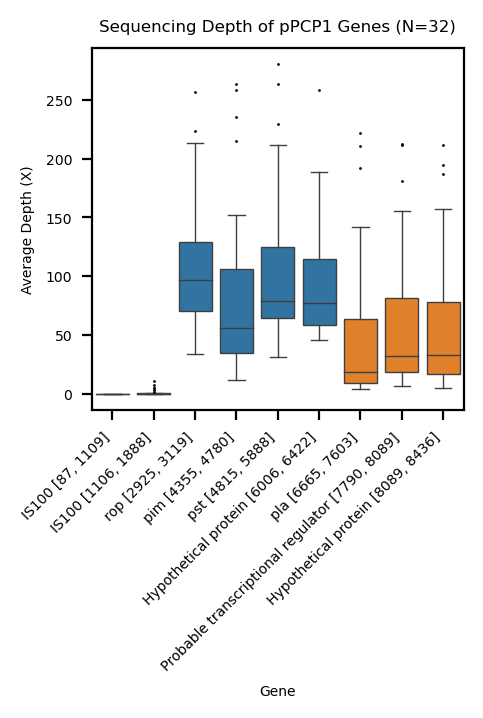

In [12]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
LOCUS_DEP = 10
RATIO = 0.7
plt.rc('font', size=FONTSIZE)

fig, axes = plt.subplots(1,1,figsize=FIGSIZE, dpi=DPI)

ax = axes
df = ppcp1_genes_df[ppcp1_genes_df["gene-YPPCP1.03"] > 10]
data = {
    col:list(df[col]) for col in df.columns
}
df = pd.DataFrame(data)
colors = [gene_labels[gene]["color"] for gene in gene_labels]
sns.boxplot(
    ax=ax,
    data=df,
    flierprops=flierprops,
    palette=colors,
)
xtick_labels = ["{} {}".format(gene_labels[gene]["label"],gene_labels[gene]["coord"])  for gene in gene_labels]
ax.set_xticklabels(xtick_labels)
plt.xticks(rotation=45, ha="right")
ax.set_xlabel("Gene")
ax.set_ylabel("Average Depth (X)")
plt.title("Sequencing Depth of pPCP1 Genes (N={})".format(len(df)))

out_path = os.path.join(out_dir, "ppcp1_gene_depth")
plt.savefig(out_path + ".png", dpi=DPI, bbox_inches = "tight", facecolor="white")
plt.savefig(out_path + ".svg", dpi=DPI, bbox_inches = "tight")

---
# Depletion Ratio

In [13]:
# Gene ID
depleted_gene = "gene-YPPCP1.07" # pla
baseline_gene = "gene-YPPCP1.05c" #pst

# Gene Label
depleted_gene_label = gene_labels[depleted_gene]["label"]
baseline_gene_label = gene_labels[baseline_gene]["label"]

# Gene Depth
baseline_dep = list(ppcp1_genes_df[baseline_gene])
depleted_dep = list(ppcp1_genes_df[depleted_gene])

# Accessory plotting variables
sample = list(ppcp1_genes_df.index)
timetree_num_date = metadata_df["timetree_num_date"][ppcp1_genes_df.index]
strain = metadata_df["strain"][ppcp1_genes_df.index]
root_rtt_dist = metadata_df["root_rtt_dist"][ppcp1_genes_df.index]

data = {
    "baseline": baseline_dep, 
    "depleted": depleted_dep, 
    "ratio": [depleted / baseline for depleted,baseline in zip(depleted_dep, baseline_dep)], 
    "sample" : sample,
    "timetree_num_date": timetree_num_date,
    "strain" : strain,
    "root_rtt_dist" : root_rtt_dist,
    }

ratio_df = pd.DataFrame(data)
ratio_df.set_index("sample", inplace=True)
ratio_df.sort_values(by="ratio", inplace=True)

display(ratio_df)

,baseline,depleted,ratio,timetree_num_date,strain,root_rtt_dist
sample,,,,,,
SAMEA5818798,64.481377,6.458999,0.100168,1608,BED024,2.44804e-05
SAMEA7313243_45,46.094971,4.741214,0.102858,1625,Azov38,2.57194e-05
SAMEA5818825,42.612663,4.544196,0.106640,1572,STN013,1.24044e-05
SAMEA5818830,82.606148,9.773163,0.118310,1568,STN021,1.21946e-05
SAMEA5818808,38.094971,4.517572,0.118587,1532,LBG002,1.21154e-05
SAMEA5818828,64.391991,7.680511,0.119277,1560,STN019,1.20081e-05
SAMEA6637004,66.663872,7.968051,0.119526,1503,AGU025,8.6439e-06
SAMEA5818822,34.228119,4.317359,0.126135,1571,STN008,1.27904e-05
SAMEA5818821,75.030724,10.085197,0.134414,1563,STN007,1.21946e-05


---
# Detect K Cluster

In [14]:
X = np.array(ratio_df["ratio"]).reshape(-1, 1)

### Elbow Method

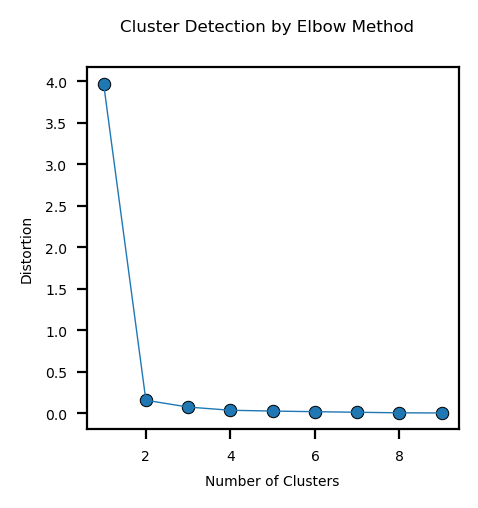

In [15]:
# calculate distortion for a range of number of cluster
distortions = []

iter = 10
for i in range(1, iter):
    km = KMeans(
        n_clusters=i, 
        init='random',
        n_init=10, 
        max_iter=300,
        tol=1e-04, 
        random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
LOCUS_DEP = 10
RATIO = 0.7
plt.rc('font', size=FONTSIZE)

fig, ax = plt.subplots(1,1,figsize=FIGSIZE, dpi=DPI)

sns.lineplot(
    ax=ax,
    x=range(1, iter), 
    y=distortions,
)
sns.scatterplot(
    ax=ax,
    x=range(1, iter), 
    y=distortions,
    s=20,
    ec="black",
    lw=0.5,
)

ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Distortion')
fig.suptitle("Cluster Detection by Elbow Method")

out_path = os.path.join(out_dir, "elbow_{}_{}".format(depleted_gene_label, baseline_gene_label))
plt.savefig(out_path + ".png", bbox_inches = "tight", facecolor="white")
plt.savefig(out_path + ".svg", bbox_inches = "tight")

## Silhoutte Clusters

In [16]:
range_n_clusters = [2, 3, 4, 5, 6]

highest_score = 0
highest_cluster = 0

for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    if silhouette_avg > highest_score:
        highest_cluster = n_clusters
        highest_score = silhouette_avg
        
# To Plot see: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters = 2 The average silhouette_score is : 0.892812128906096
For n_clusters = 3 The average silhouette_score is : 0.83099106830999
For n_clusters = 4 The average silhouette_score is : 0.6606709118722323
For n_clusters = 5 The average silhouette_score is : 0.6216665888291917
For n_clusters = 6 The average silhouette_score is : 0.5974021466442636


---
# Cluster

In [17]:
km = KMeans(
    n_clusters=highest_cluster, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

for ratio, cluster, sample in zip(X, y_km, ratio_df.index):
    ratio_df.at[sample, "cluster"] = cluster
    
#display(ratio_df)
cluster_max_ratios = {cluster:0 for cluster in range(0, highest_cluster)}

for cluster in range(0, highest_cluster):
    ratios = [r[0] for r in X[y_km == cluster]]
    cluster_max_ratios[cluster] = max(ratios)

cluster_order = list({cluster:ratio for cluster,ratio in sorted(cluster_max_ratios.items(), key=lambda item: item[1])}.keys())

for rec in ratio_df.iterrows():
    sample = rec[0]
    cluster = rec[1]["cluster"]
    new_cluster = cluster_order.index(cluster)
    ratio_df.at[sample, "cluster"] = new_cluster
    
    
display(ratio_df)

,baseline,depleted,ratio,timetree_num_date,strain,root_rtt_dist,cluster
sample,,,,,,,
SAMEA5818798,64.481377,6.458999,0.100168,1608,BED024,2.44804e-05,0.0
SAMEA7313243_45,46.094971,4.741214,0.102858,1625,Azov38,2.57194e-05,0.0
SAMEA5818825,42.612663,4.544196,0.106640,1572,STN013,1.24044e-05,0.0
SAMEA5818830,82.606148,9.773163,0.118310,1568,STN021,1.21946e-05,0.0
SAMEA5818808,38.094971,4.517572,0.118587,1532,LBG002,1.21154e-05,0.0
SAMEA5818828,64.391991,7.680511,0.119277,1560,STN019,1.20081e-05,0.0
SAMEA6637004,66.663872,7.968051,0.119526,1503,AGU025,8.6439e-06,0.0
SAMEA5818822,34.228119,4.317359,0.126135,1571,STN008,1.27904e-05,0.0
SAMEA5818821,75.030724,10.085197,0.134414,1563,STN007,1.21946e-05,0.0


---
## Plot

No handles with labels found to put in legend.


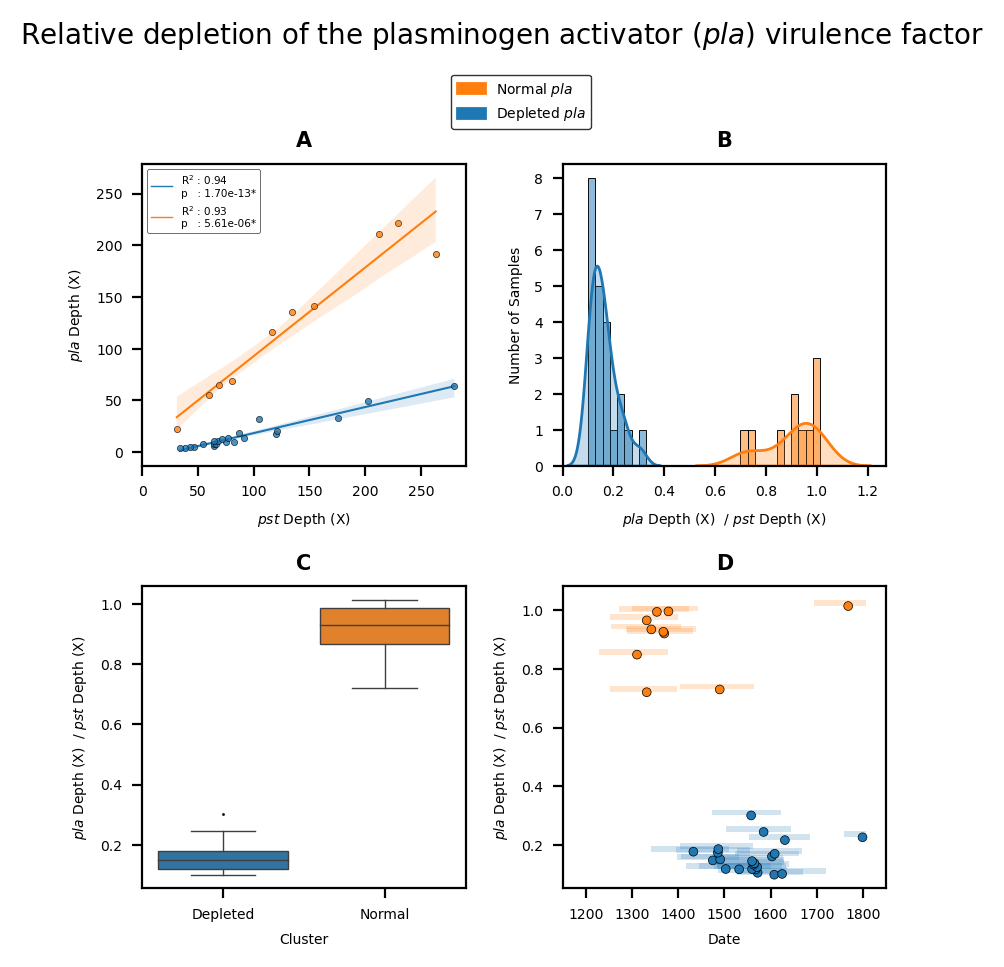

In [18]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [960, 960]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=5
LOCUS_DEP = 10
RATIO = 0.7
plt.rc('font', size=FONTSIZE)

fig, axes = plt.subplots(2,2,figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

#------------------------------------------------
# Regresion
ax = axes[0][0]
ax.set_title("A", fontsize=FONTSIZE * 1.5, fontweight="bold")

for cluster in range(0, highest_cluster):
    sns.regplot(
        ax=ax,
        data=ratio_df[ratio_df["cluster"] == cluster],
        x="baseline",
        y="depleted", 
        #ci=None,
        scatter_kws={"s": 5, "ec":"black", "lw": 0.25, "zorder":1},   
        line_kws={"zorder":0},
    )
    
ax.set_xlabel("$\it{" + "{}".format(baseline_gene_label) + "}$ Depth (X)")
ax.set_ylabel("$\it{" + "{}".format(depleted_gene_label) + "}$ Depth (X)")
ax.set_xlim(0, max(ratio_df["baseline"] + 10))

reg_handles = []
for cluster in range(highest_cluster):
    cluster_df = ratio_df[ratio_df["cluster"] ==cluster]
    x = list(cluster_df["baseline"])
    y = list(cluster_df["depleted"])
    slope, intercept, r_value, p_value, stderr, = scipy.stats.linregress(x,y)
    
    p_sig = ""
    if p_value < 0.05:
        p_sig = "*"
        
    r_squared = r_value * r_value
    r_squared_pretty = str(round(r_squared, 2))
    
    intercept_pretty = "+ " + str(round(intercept, 2)).replace("+","")
    if "-" in str(intercept):
        intercept_pretty = "- " + str(round(intercept, 2)).replace("-","")
        
    reg_handles.append(
        lines.Line2D([0], [0], 
        label = (
            "R$^{2}$ : " + "{}".format(r_squared_pretty)
            #"y = {}x {}".format(round(slope,2),intercept_pretty)
            + "\np   : {:0.2e}{}".format(p_value, p_sig)
        ),
        color=D3_COL_PAL[cluster])
    )

legend = ax.legend(handles=reg_handles, loc=2, fontsize=FONTSIZE * 0.75, edgecolor="black")
legend.get_frame().set_linewidth(0.25)

#------------------------------------------------
# Histogram
ax = axes[0][1]
ax.set_title("B", fontsize=FONTSIZE * 1.5, fontweight="bold")
sns.histplot(
    ax=ax,
    data=ratio_df,
    x="ratio",
    bins=len(ratio_df),
    hue="cluster",
    palette = D3_COL_PAL[0:highest_cluster],
    #alpha=0.75,
    zorder=0,
)
sns.kdeplot(
    ax=ax,
    data=ratio_df,
    x="ratio",
    hue="cluster",
    palette = D3_COL_PAL[0:highest_cluster],
    #alpha=1.0,
    fill=True,
    zorder=1,
)



ax.set_xlim(0)
ax.set_ylabel("Number of Samples")
ax.set_xlabel(
    "$\it{" 
    + "{}".format(depleted_gene_label)
    + "}$ Depth (X)  / $\it{"
    + "{}".format(baseline_gene_label)
    + "}$ Depth (X)")
ax.legend().remove()

#------------------------------------------------
# Boxplot
# Genetic Distance
ax = axes[1][0]
ax.set_title("C", fontsize=FONTSIZE * 1.5, fontweight="bold")

sns.boxplot(
    ax=ax,
    data=ratio_df,
    x="cluster",
    y="ratio",
    flierprops=flierprops,
)
ax.set_xlabel("Cluster")
ax.set_xticklabels(["Depleted", "Normal"])
ax.set_ylabel(
    "$\it{" 
    + "{}".format(depleted_gene_label)
    + "}$ Depth (X)  / $\it{"
    + "{}".format(baseline_gene_label)
    + "}$ Depth (X)")

"""sns.scatterplot(
    ax=ax, 
    data=ratio_df, 
    x="root_rtt_dist", 
    y="ratio",
    s=10,
    ec="black",
    palette = D3_COL_PAL[0:highest_cluster],
    hue="cluster",    
 
)
ax.set_xlabel("Genetic Distance to the Root")
ax.set_ylabel(
    "$\it{" 
    + "{}".format(depleted_gene_label)
    + "}$ Depth (X)  / $\it{"
    + "{}".format(baseline_gene_label)
    + "}$ Depth (X)")
ax.legend().remove()"""

# --------------------------------------
# TIMELINE
ax = axes[1][1]
ax.set_title("D", fontsize=FONTSIZE * 1.5, fontweight="bold")
sns.scatterplot(
    ax=ax, 
    data=ratio_df, 
    x="timetree_num_date", 
    y="ratio",
    s=10,
    ec="black",
    palette = D3_COL_PAL[0:highest_cluster],
    hue="cluster",    
 
)
ax.legend().remove()

#------------------------------------------------
# Date Confidences
for sample in ratio_df.index:
    conf = [float(c) for c in metadata_df["timetree_num_date_confidence"][sample].strip("[]").split(",")]
    ratio = ratio_df["ratio"][sample]
    cluster = int(ratio_df["cluster"][sample])
    color = D3_COL_PAL[cluster]
    ax.add_patch(
        patches.Rectangle(
            (conf[0], ratio), conf[1] - conf[0], 0.02, linewidth=0, facecolor=color, alpha=0.20, zorder=0))


ax.set_xlim(1150,1850)
ax.set_xlabel("Date")
ax.set_ylabel(
    "$\it{" 
    + "{}".format(depleted_gene_label)
    + "}$ Depth (X)  / $\it{"
    + "{}".format(baseline_gene_label)
    + "}$ Depth (X)")

#------------------------------------------------
# Legend
normal_patch = patches.Patch(color=D3_COL_PAL[1], label='Normal $\it{pla}$')
low_patch = patches.Patch(color=D3_COL_PAL[0], label='Depleted $\it{pla}$')
legend = fig.legend(handles=[normal_patch, low_patch], bbox_to_anchor=(0.6,0.98), edgecolor="black")
legend.get_frame().set_linewidth(0.5)

fig.suptitle(
    "Relative depletion of the plasminogen activator ($\it{pla}$) virulence factor", 
    x=0.5, 
    y=1.03, 
    fontsize=FONTSIZE * 2,
)

out_path = os.path.join(out_dir, "depletion_{}".format(depleted_gene_label))
plt.savefig(out_path + ".png", bbox_inches = "tight", facecolor="white")
plt.savefig(out_path + ".svg", bbox_inches = "tight")

## Add Depletion Statistics to Metadata

In [19]:
metadata_df["baseline_{}".format(baseline_gene_label)] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["depleted_{}".format(depleted_gene_label)] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["ratio_{}_{}".format(depleted_gene_label, baseline_gene_label)] = [NO_DATA_CHAR] * len(metadata_df)
metadata_df["cluster_{}_{}".format(depleted_gene_label, baseline_gene_label)] = [NO_DATA_CHAR] * len(metadata_df)

for rec in ratio_df.iterrows():
    sample = rec[0]
    metadata_df.at[sample, "baseline_{}".format(baseline_gene_label)] = rec[1]["baseline"]
    metadata_df.at[sample, "depleted_{}".format(depleted_gene_label)] = rec[1]["depleted"]
    metadata_df.at[sample, "ratio_{}_{}".format(depleted_gene_label, baseline_gene_label)] = rec[1]["ratio"]
    metadata_df.at[sample, "cluster_{}_{}".format(depleted_gene_label, baseline_gene_label)] = rec[1]["cluster"]
    
display(metadata_df)

,strain,date,date_bp,country,province,...,continuous_geo_lon,baseline_pst,depleted_pla,ratio_pla_pst,cluster_pla_pst
sample,,,,,,,,,,,
SAMEA5818830,STN021,[1485:1635],[-536:-386],Switzerland,Nidwalden,...,NA,82.6061,9.77316,0.11831,0
SAMEA5818829,STN020,[1485:1635],[-536:-386],Switzerland,Nidwalden,...,NA,91.2598,13.3642,0.146441,0
SAMEA5818828,STN019,[1485:1635],[-536:-386],Switzerland,Nidwalden,...,NA,64.392,7.68051,0.119277,0
SAMEA5818826,STN014,[1485:1635],[-536:-386],Switzerland,Nidwalden,...,NA,104.818,31.6113,0.301584,0
SAMEA5818825,STN013,[1485:1635],[-536:-386],Switzerland,Nidwalden,...,NA,42.6127,4.5442,0.10664,0
SAMEA5818822,STN008,[1485:1635],[-536:-386],Switzerland,Nidwalden,...,NA,34.2281,4.31736,0.126135,0
SAMEA5818821,STN007,[1485:1635],[-536:-386],Switzerland,Nidwalden,...,NA,75.0307,10.0852,0.134414,0
SAMEA5818818,STN002,[1485:1635],[-536:-386],Switzerland,Nidwalden,...,NA,54.9088,7.63578,0.139063,0
SAMEA5818817,STA001,[1420:1630],[-601:-391],Germany,Bavaria,...,NA,71.3101,12.7199,0.178375,0


## Draw Tree

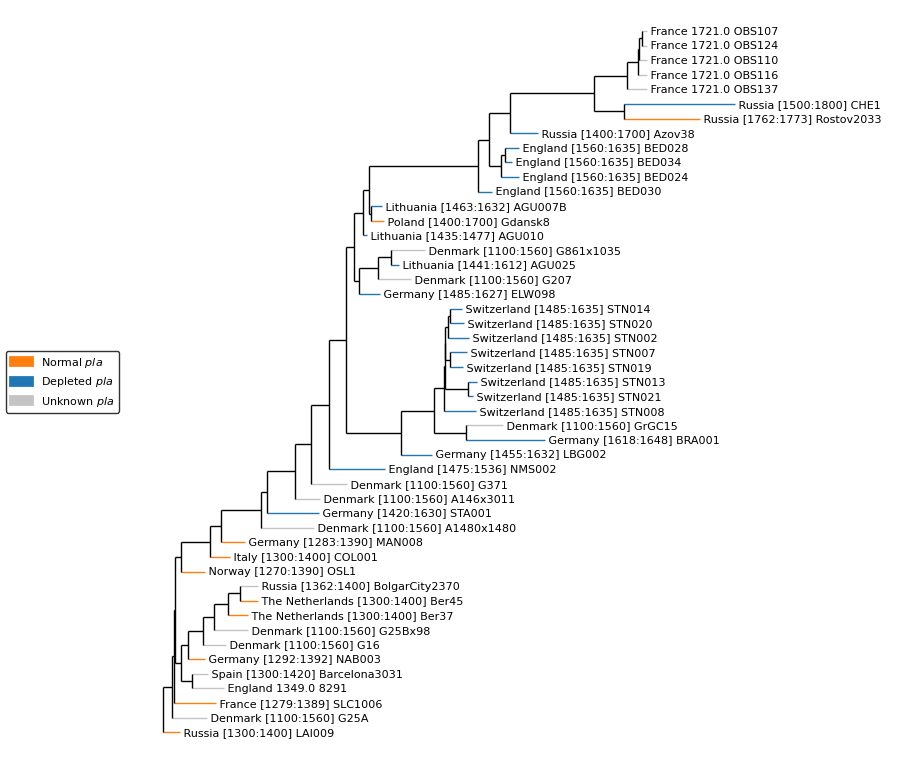

In [20]:
for c in tree.get_terminals():
    sample = c.name
    cluster = metadata_df["cluster_{}_{}".format(depleted_gene_label, baseline_gene_label)][sample]
    if cluster == NO_DATA_CHAR:
        color = "#c4c4c4"
    else:
        color = D3_COL_PAL[int(cluster)]
    c.color = color

# ---------------------------------------
# PLOT SETUP
TARGET_RES = [960, 960]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=4
LOCUS_DEP = 10
RATIO = 0.7
plt.rc('font', size=FONTSIZE)

fig, ax = plt.subplots(1,figsize=FIGSIZE, dpi=DPI)

Phylo.draw(
    tree, 
    axes=ax, 
    show_confidence=False, 
    label_func = lambda x: metadata_df["country_date_strain"][x.name] if x.is_terminal() else "", 
    do_show=False
)

ax.axis("off")
#ax.set_ylabel("")
#ax.set_yticklabels([])
#ax.set_xlabel("Years")

#------------------------------------------------
# Legend
normal_patch = patches.Patch(color=D3_COL_PAL[1], label='Normal $\it{pla}$')
low_patch = patches.Patch(color=D3_COL_PAL[0], label='Depleted $\it{pla}$')
unknown_patch = patches.Patch(color="#c4c4c4", label='Unknown $\it{pla}$')
legend = fig.legend(handles=[normal_patch, low_patch, unknown_patch], loc=6, edgecolor="black")
legend.get_frame().set_linewidth(0.5)

out_path = os.path.join(out_dir, "depletion_tree_{}".format(depleted_gene_label))
plt.savefig(out_path + ".png", bbox_inches = "tight", facecolor="white")
plt.savefig(out_path + ".svg", bbox_inches = "tight")

# Export

## Metadata

In [21]:
out_path_metadata = os.path.join(out_dir, "metadata.tsv")
metadata_df.to_csv(out_path_metadata, sep="\t", index=True)

## Timetree

In [22]:
out_tree = copy.deepcopy(tree)

metadata_to_comment(out_tree, metadata_df)    
out_path_tree_nex = os.path.join(out_dir, "all.timetree.nex")
Phylo.write(out_tree, out_path_tree_nex, "nexus")

1